In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def web_search(query):
    """A function that does web search for a specific query whenever the llm doesnt have the answer to a given question in its outdated database"""
    return TavilySearch(max_results=5).invoke(query)

tools = [add, multiply, divide, web_search]
llm = ChatOpenAI(model="gpt-4o-mini")

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [4]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

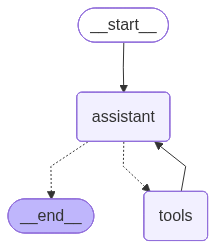

In [5]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
messages = [HumanMessage(content="Add 6 and 4. Multiply the output by 9. Divide the output by 11. Then search the lastest news on AI")]
messages = react_graph.invoke({"messages": messages})

In [7]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 6 and 4. Multiply the output by 9. Divide the output by 11. Then search the lastest news on AI
================================== Ai Message ==================================
Tool Calls:
  add (call_5G8QgIStj7rcGX43J45MSqJf)
 Call ID: call_5G8QgIStj7rcGX43J45MSqJf
  Args:
    a: 6
    b: 4
================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================
Tool Calls:
  multiply (call_pa8R7D42OfTNRUxjz2N0rGlo)
 Call ID: call_pa8R7D42OfTNRUxjz2N0rGlo
  Args:
    a: 10
    b: 9
================================= Tool Message =================================
Name: multiply

90
================================== Ai Message ==================================
Tool Calls:
  divide (call_qoIQvcagRDsI7ictnuNXiLLm)
 Call ID: call_qoIQvcagRDsI7ictnuNXiLLm
  Args:
    a: 90
    b: 11
======================

In [8]:
messages = [HumanMessage(content="Evaluate this expression (((6+7)*34)/10)")]
messages = react_graph.invoke({"messages": messages})

In [9]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Evaluate this expression (((6+7)*34)/10)
================================== Ai Message ==================================
Tool Calls:
  add (call_ezRJ3IjpJ590JKui5aSOfI1d)
 Call ID: call_ezRJ3IjpJ590JKui5aSOfI1d
  Args:
    a: 6
    b: 7
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================
Tool Calls:
  multiply (call_jLVOLeaYRU34sS1ZzywblzlF)
 Call ID: call_jLVOLeaYRU34sS1ZzywblzlF
  Args:
    a: 13
    b: 34
================================= Tool Message =================================
Name: multiply

442
================================== Ai Message ==================================
Tool Calls:
  divide (call_Xd0Cbr7CpxXs4JVgTswfRaTx)
 Call ID: call_Xd0Cbr7CpxXs4JVgTswfRaTx
  Args:
    a: 442
    b: 10
================================= Tool Message ==============================

In [ ]:
%%sql


### IN LANGGRAPH STUDIO

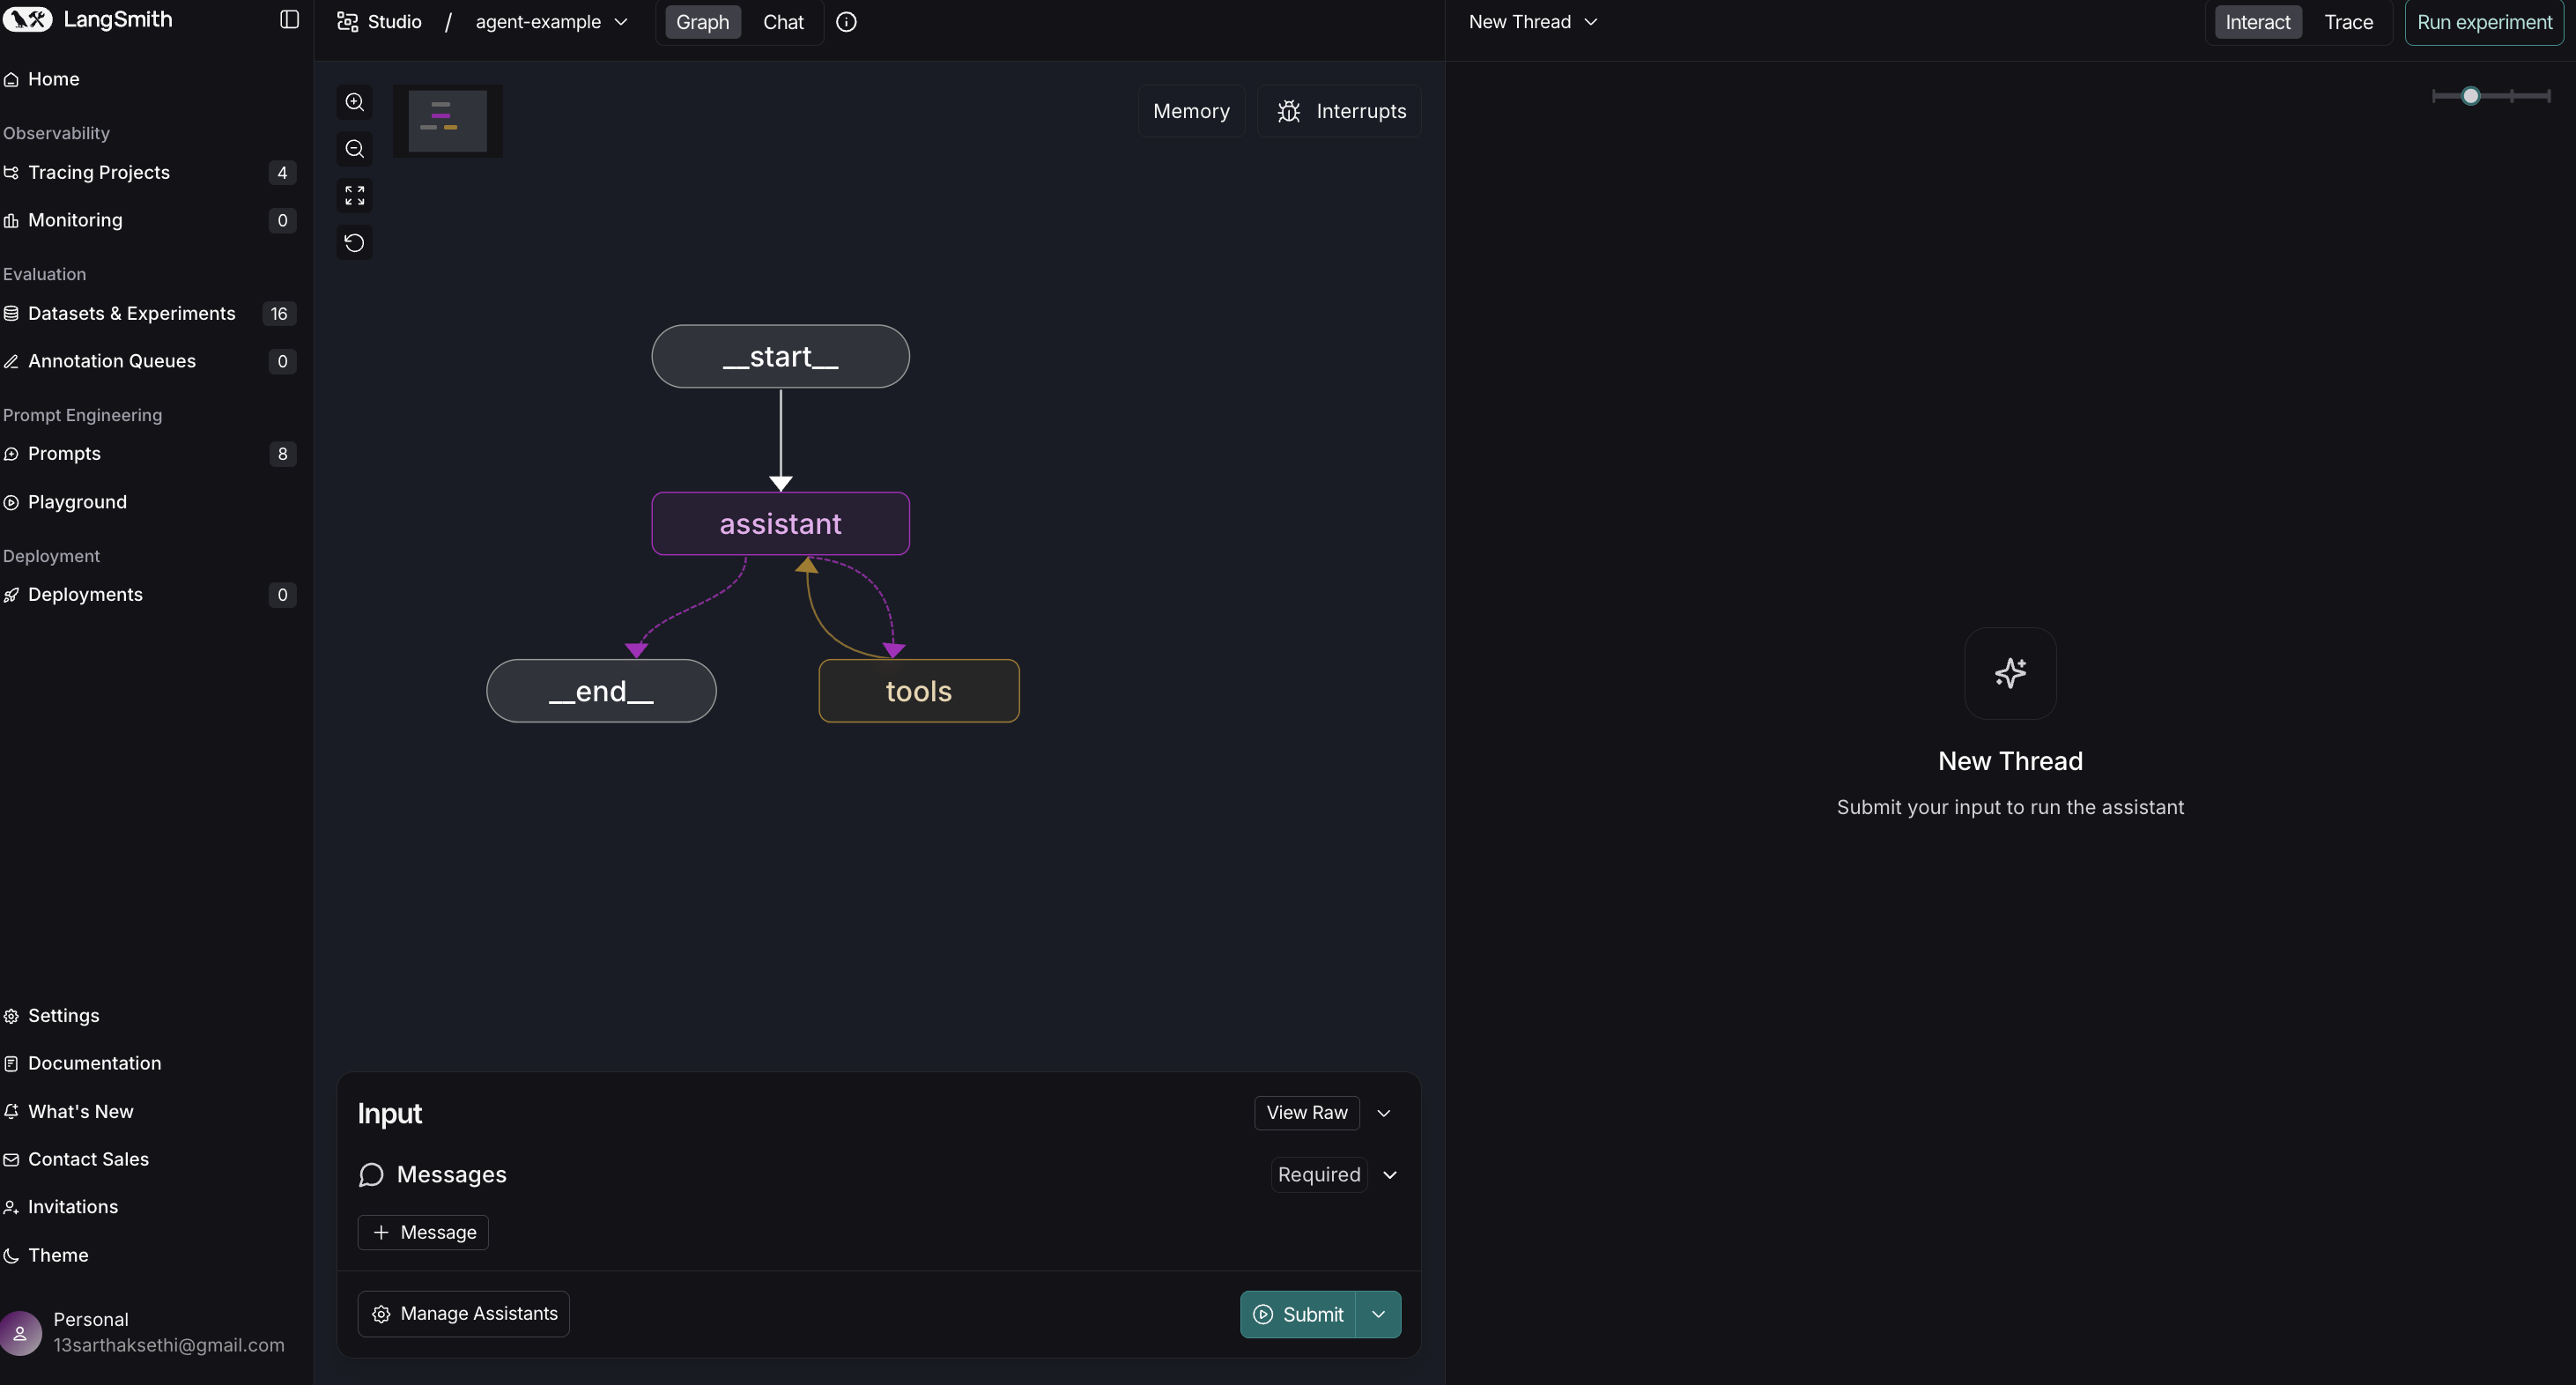

Running a few prompts

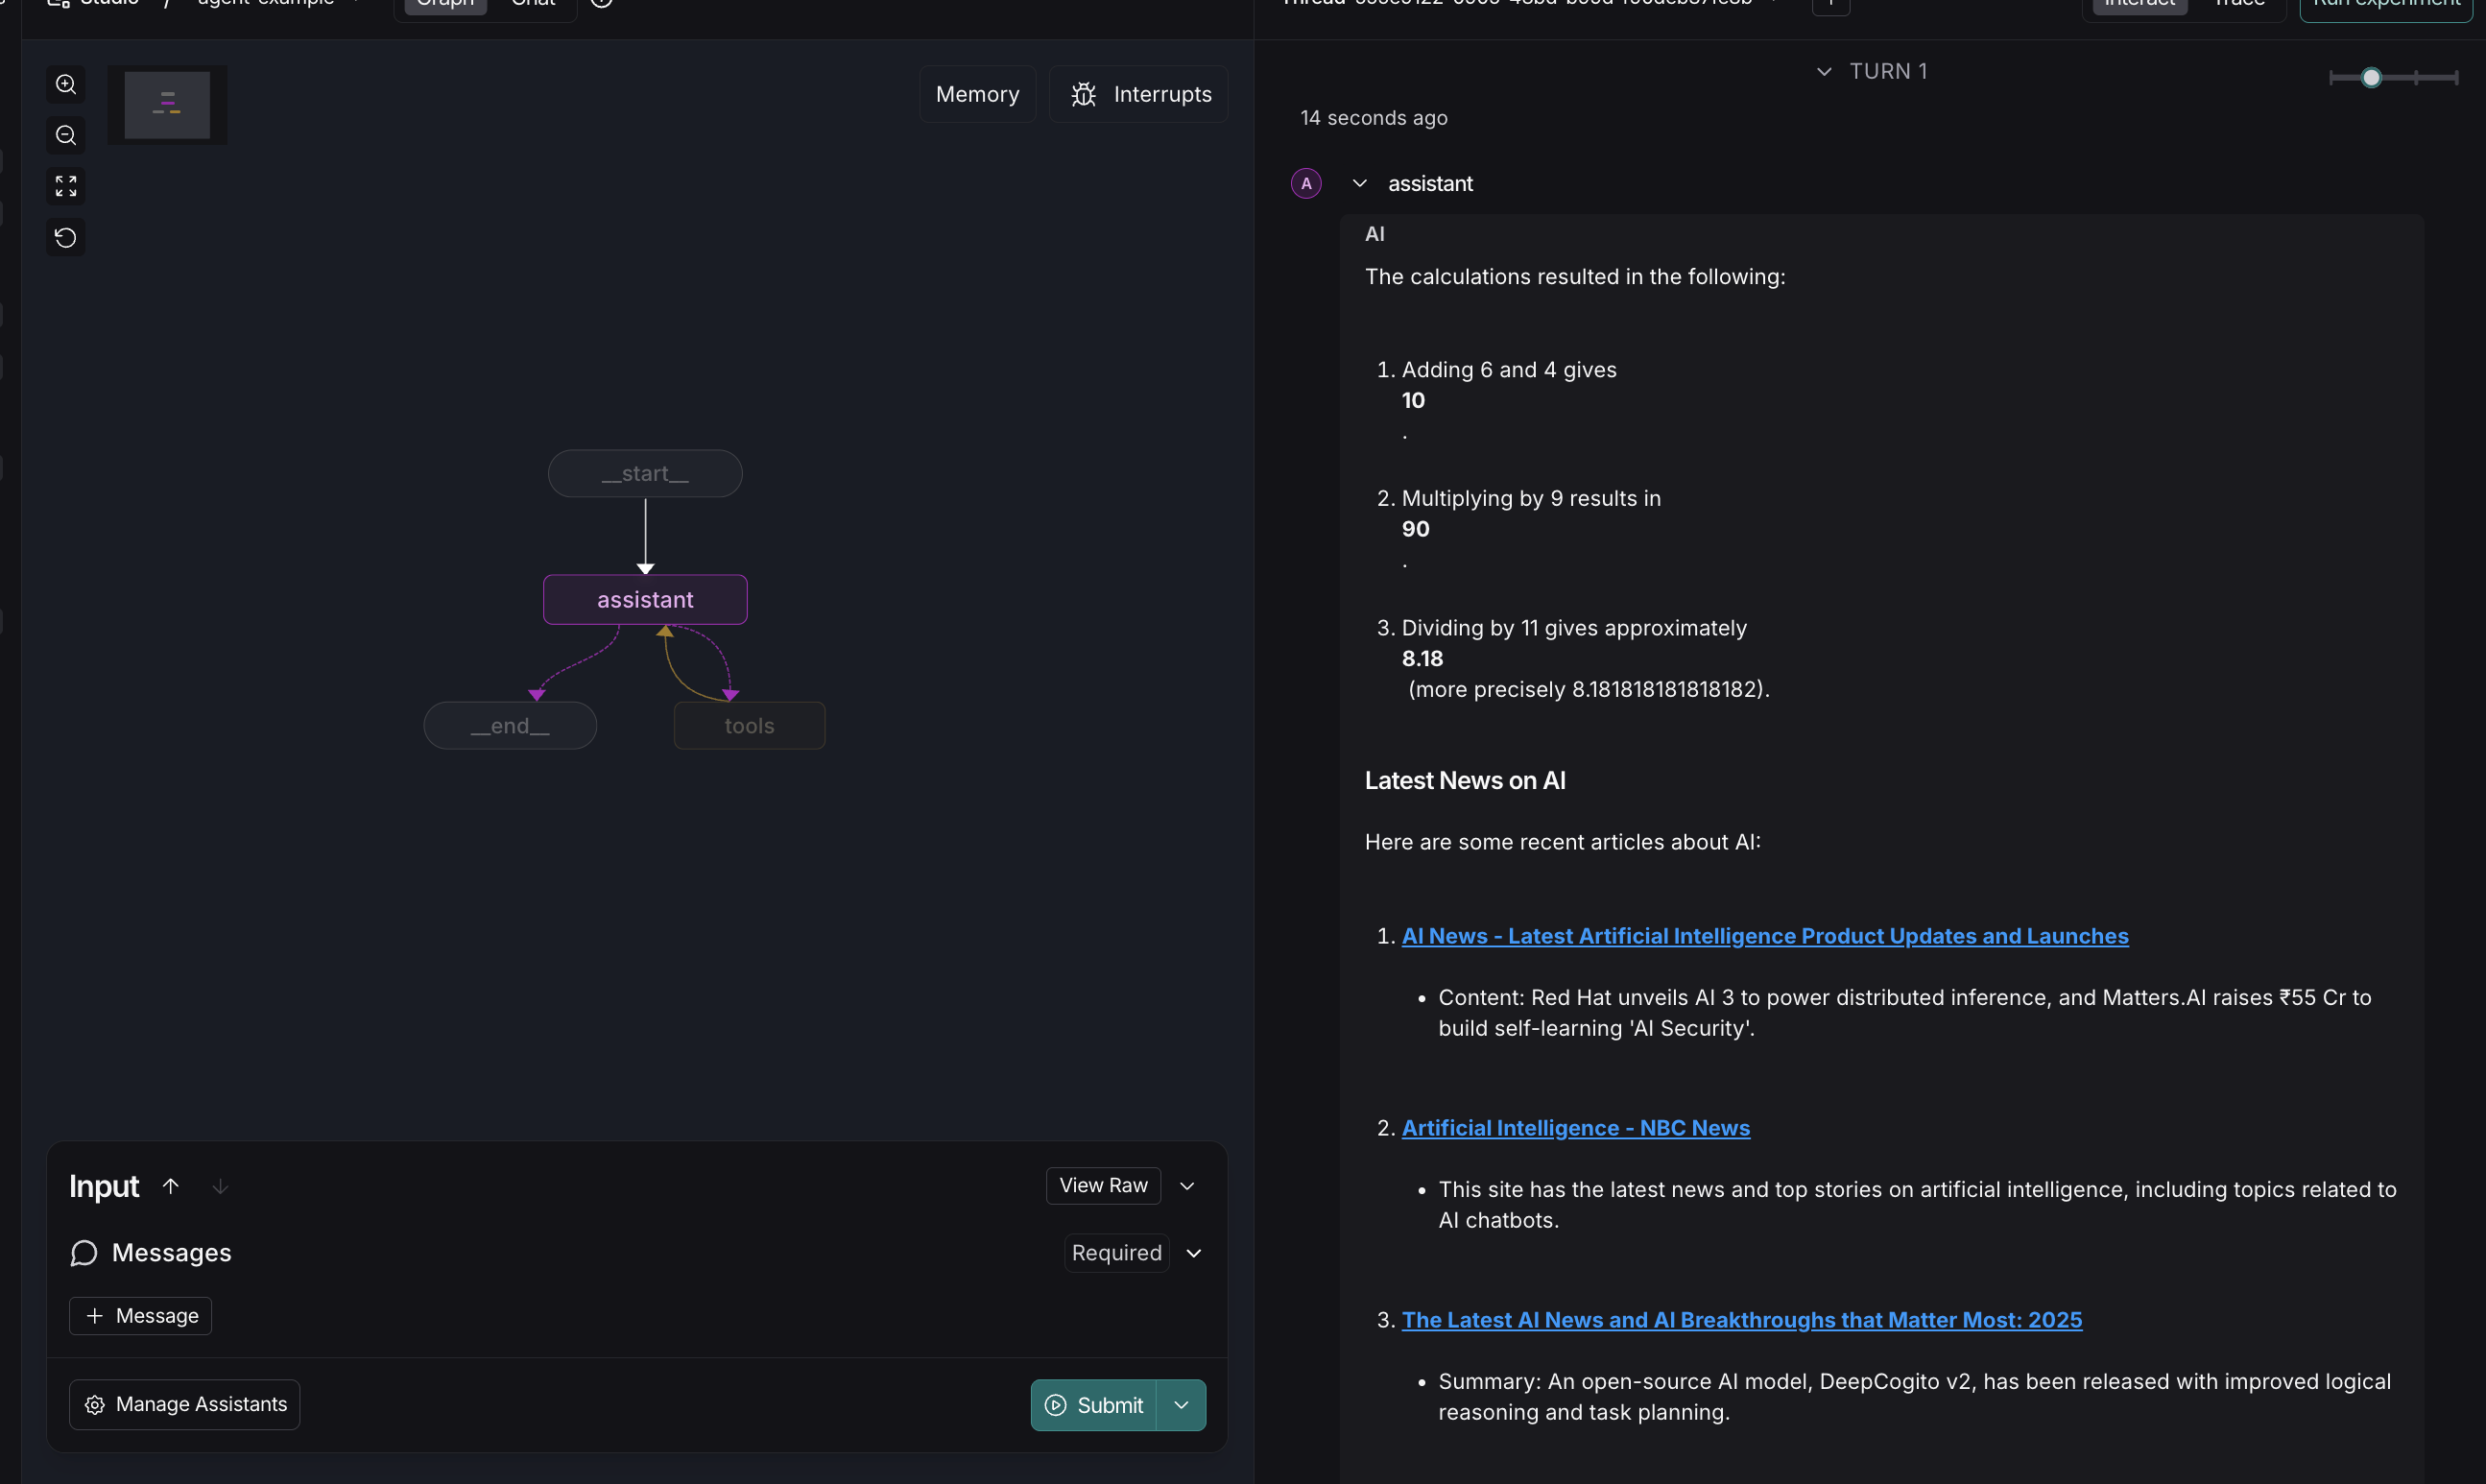

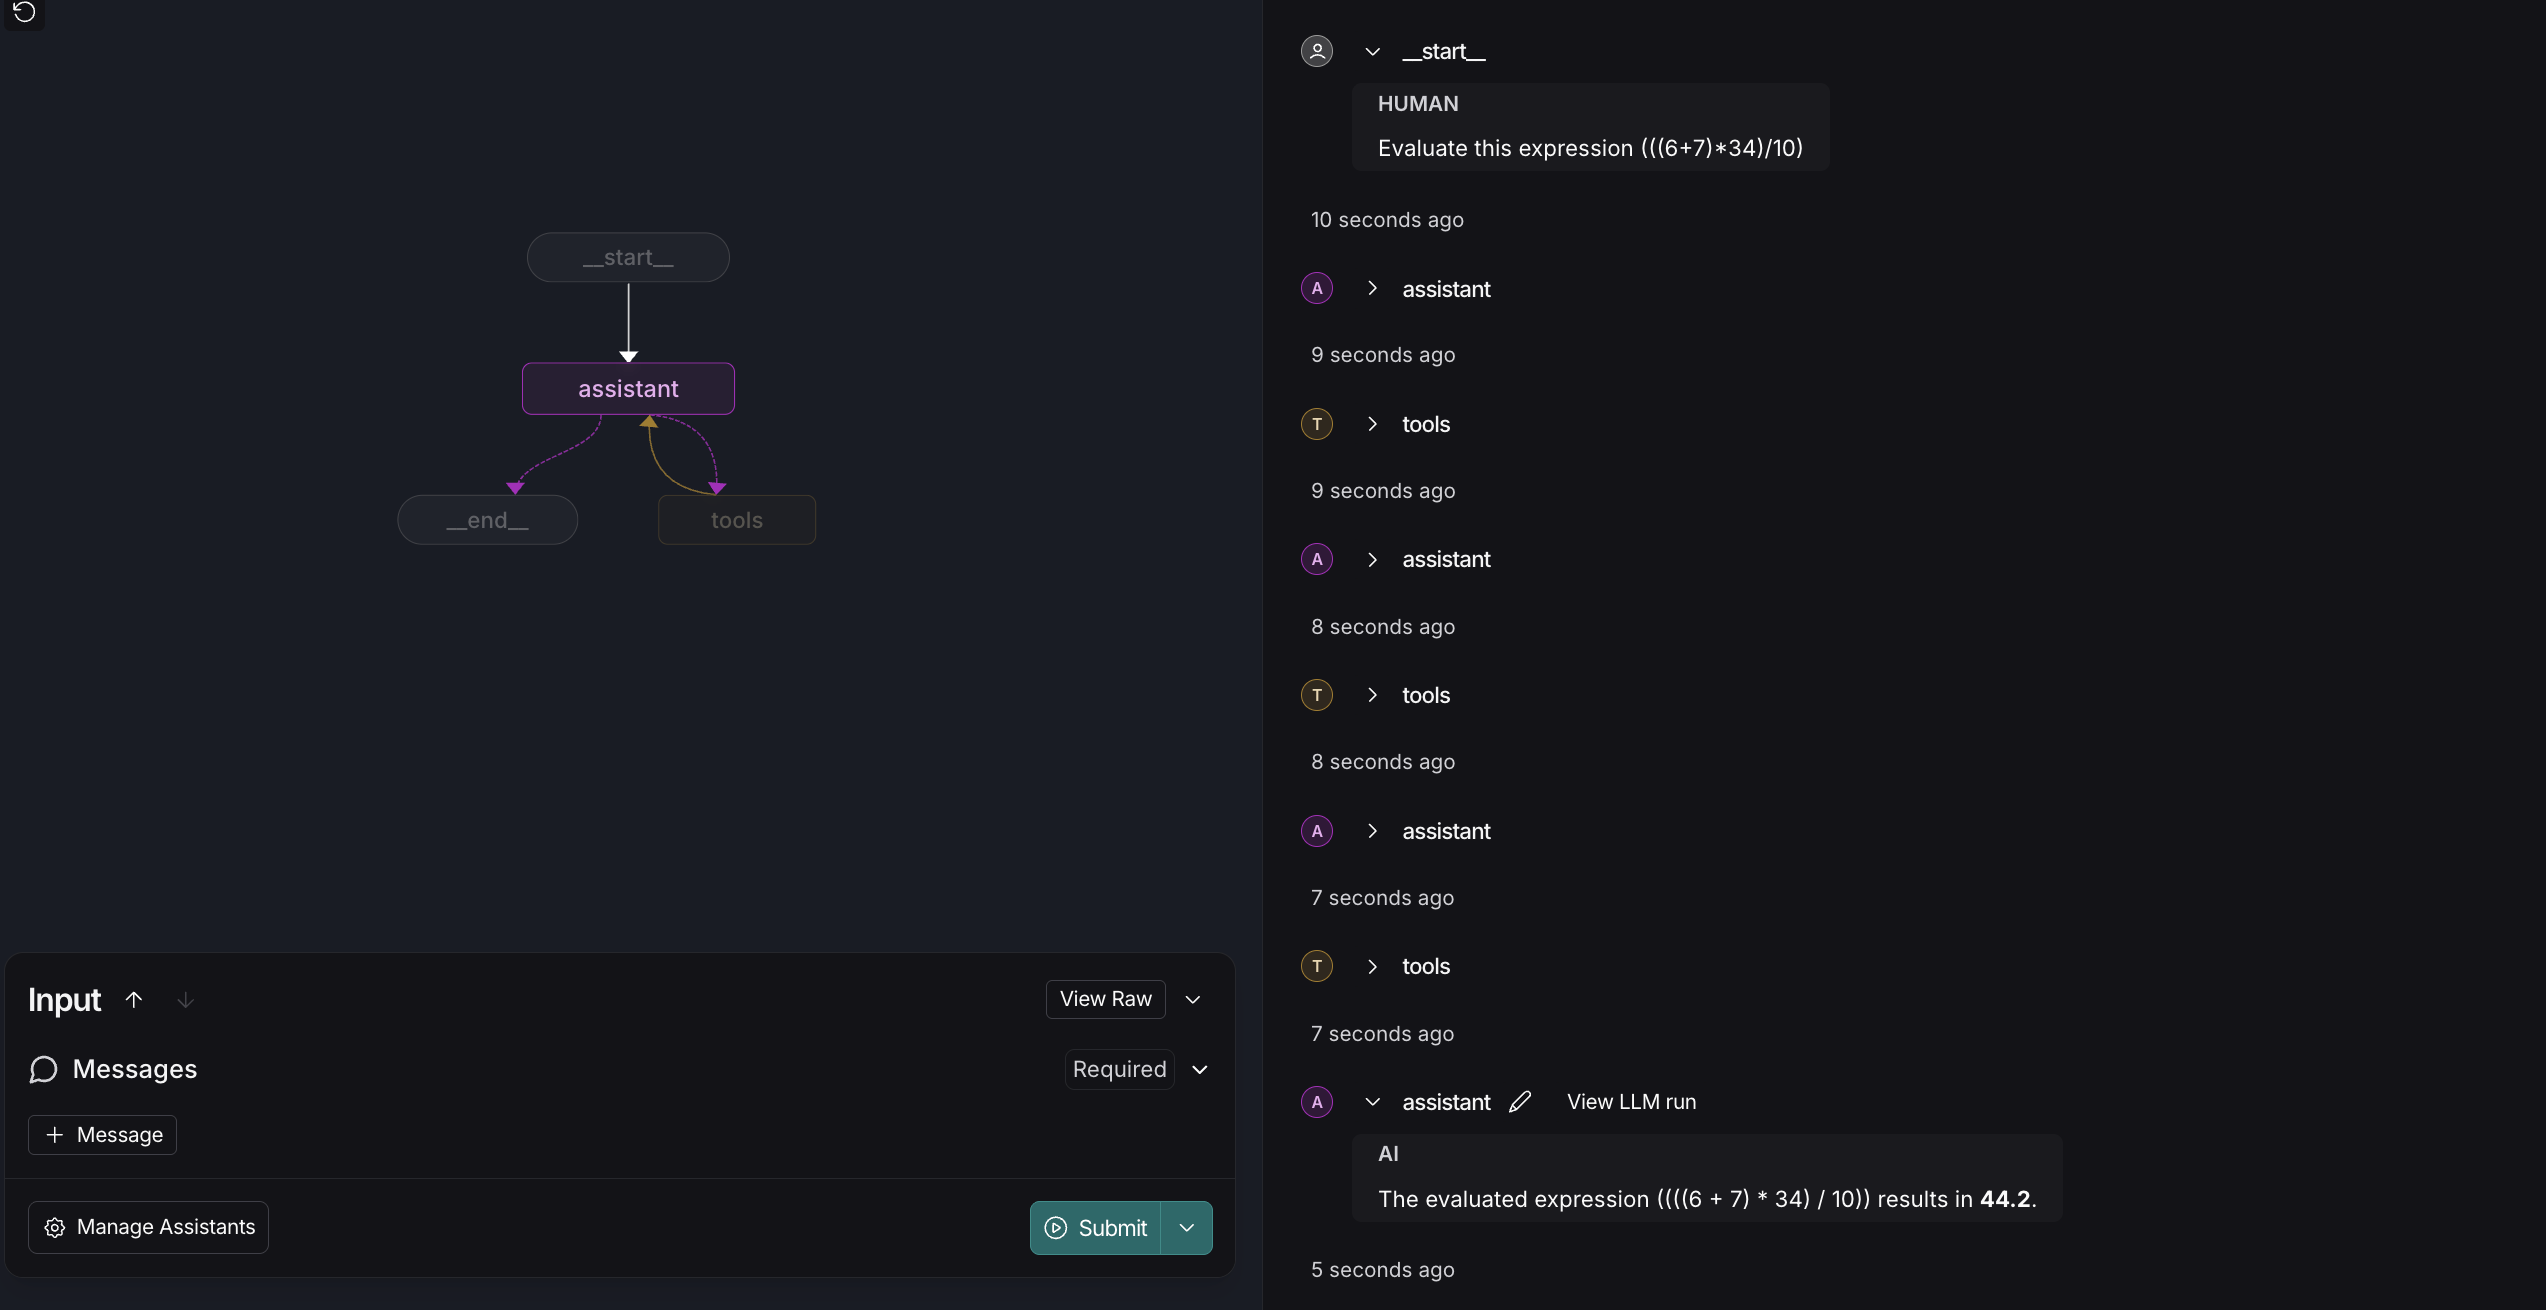